In [9]:
import torchinfo
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from torchvision.models.feature_extraction import create_feature_extractor
from torch.nn.functional import kl_div
from scipy.spatial.distance import jensenshannon
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
from datetime import datetime
from torchview import draw_graph
import sys

device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")
dtype = torch.double

%run /tigress/kendrab/analysis-notebooks/torch_models/import_mms_data.ipynb
%run /tigress/kendrab/analysis-notebooks/torch_models/utils.ipynb
%run /tigress/kendrab/analysis-notebooks/torch_models/ndb.ipynb

Using cpu device
Using cpu device


### Manually adding necessary stuff

In [10]:
# create dataframe to hold summary of all this shit
feat_extractors_df = pd.DataFrame(index=['sim_sim','sim_mms','adda_knee','adda_skill', 'adda_skillup','adda_ndb',
                                         'discrim_ndb','discrim_kl', 'discrim_relu', 'discrim_copy', 'random'],
                                  columns=['model', 'model_path','data','num_runs', 'hyperparams', 'weights_mean', 'weights_stdev',
                                           'feat_size_mean','ndb_score_25','ndb_score_100', 'kl_div', 'js_dist','rope_acc','loop_acc','neg_acc','rope_acc_0','loop_acc_0','neg_acc_0'])

In [3]:
#TODO add info for discrim models
#add (some) paths to df (sim is special boyeee)
feat_extractors_df.loc['random','model_path'] = "/tigress/kendrab/analysis-notebooks/model_outs/sim_random_featextract_statedict.tar"
feat_extractors_df.loc['adda_skill','model_path'] = "/tigress/kendrab/analysis-notebooks/model_outs/18-10-24/adda_2162235_95mms_classifier_statedict.tar"
feat_extractors_df.loc['adda_skillup','model_path'] = "/tigress/kendrab/analysis-notebooks/model_outs/21-10-24/adda_2181157_24mms_classifier_statedict.tar"
feat_extractors_df.loc['adda_knee','model_path'] = "/tigress/kendrab/analysis-notebooks/model_outs/18-10-24/adda_2162235_21mms_classifier_statedict.tar"
feat_extractors_df.loc['adda_ndb','model_path'] = "/tigress/kendrab/analysis-notebooks/model_outs/20-09-24/adda_ndb190550_95mms_classifier_statedict.tar"
feat_extractors_df.loc['discrim_ndb', 'model_path'] = "/tigress/kendrab/analysis-notebooks/model_outs/24-10-24/da_dist145931_13mms_classifier_statedict.tar"
feat_extractors_df.loc['discrim_kl','model_path'] = "/tigress/kendrab/analysis-notebooks/model_outs/25-10-24/da_dist130101_64mms_classifier_statedict.tar"
feat_extractors_df.loc['discrim_relu','model_path'] = "/tigress/kendrab/analysis-notebooks/model_outs/30-10-24/da_dist201250_46mms_classifier_statedict.tar"
feat_extractors_df.loc['discrim_copy','model_path'] = "/tigress/kendrab/analysis-notebooks/model_outs/02-11-24/da_sim003333_62mms_classifier_statedict.tar"
#path to MMS data
mms_data_loc = '/tigress/kendrab/analysis-notebooks/mms_data/mms_slices/'

#path to Smith data
smith_loop_path = "/tigress/kendrab/analysis-notebooks/mms_data/smith_dataset/loop_slices.h5"
smith_rope_path = "/tigress/kendrab/analysis-notebooks/mms_data/smith_dataset/rope_slices.h5"
negative_path = "/tigress/kendrab/analysis-notebooks/mms_data/smith_dataset/negative_slices.h5"

# feature picture path
feat_path = "/tigress/kendrab/analysis-notebooks/model_outs/feat_comparison.pdf"

loss_fn = nn.BCEWithLogitsLoss(reduction='mean') 
# some sim model hyperparameters
padding_length = 39  # amount of data on each side of each segment for additional info
stride = 11  # size (and therefore spacing) of each segment
input_length = stride + 2*padding_length
og_batch_size = 11
batch_size = og_batch_size
feat_shape = [batch_size, 72, 3]
mock_data = torch.ones((batch_size, 1, input_length), dtype=dtype)  # one of the inputs, not all
n = 10000

In [4]:
# manually add hyperparameters
feat_extractors_df.loc['adda_ndb','hyperparams'] = [{'num_conv': 1, 'kernel_size': 3, 'pool_size': 4, 'out_channels': 40, 'learning_rate': 0.0012094769607738786,
                                                    'dropout': 0.03457536835651724, 'discrim_width': 132, 'discrim_length': 3}]
feat_extractors_df.loc['adda_skill','hyperparams'] = [{'num_conv': 2, 'kernel_size': 2, 'pool_size': 2, 'out_channels': 24, 'learning_rate': 0.0011048871605494912,
                                                      'dropout': 0.0010215187514899526, 'discrim_width': 192, 'discrim_length': 2}]
feat_extractors_df.loc['adda_knee','hyperparams'] = [{'num_conv': 2, 'kernel_size': 2, 'pool_size': 2, 'out_channels': 24, 'learning_rate': 0.0010009784145533697,
                                                    'dropout': 0.22257936970521033, 'discrim_width': 197, 'discrim_length': 2}]
feat_extractors_df.loc['adda_skillup','hyperparams'] = [{'num_conv': 2, 'kernel_size': 2, 'pool_size': 2, 'out_channels': 31, 'learning_rate': 0.0012500692809411574,
                                                         'dropout': 0.039506377183051694, 'discrim_width': 88, 'discrim_length': 1}]
feat_extractors_df.loc['discrim_ndb','hyperparams'] = [{'num_conv': 1, 'kernel_size': 5, 'pool_size': 2, 'out_channels': 30, 'learning_rate': 0.0010309164644968047,
                                                        'dropout': 0.07315840313210928}]
feat_extractors_df.loc['discrim_kl','hyperparams'] = [{'num_conv': 2, 'kernel_size': 2, 'pool_size': 2, 'out_channels': 52, 'learning_rate': 0.0020295619752822426,
                                                       'dropout': 0.18343836540759825}]
feat_extractors_df.loc['discrim_relu','hyperparams'] = [{'num_conv': 2, 'kernel_size': 2, 'pool_size': 2, 'out_channels': 45, 'learning_rate': 0.001068209313128857, 'dropout': 0.10023415808521953}]

In [5]:
# manually add number of runs
feat_extractors_df.loc['adda_ndb','num_runs'] = 289
feat_extractors_df.loc[['adda_skill', 'adda_knee','adda_skillup'],'num_runs'] = 993
feat_extractors_df.loc['discrim_ndb','num_runs'] = 282
feat_extractors_df.loc['discrim_kl','num_runs'] = 287
feat_extractors_df.loc['discrim_relu','num_runs'] = 288
feat_extractors_df.loc['discrim_copy','num_runs'] = 289

In [6]:
# define what type of data we are comparing to sim data
feat_extractors_df.loc['sim_sim','data'] = 'sim'
feat_extractors_df.loc[feat_extractors_df.index != 'sim_sim','data'] = 'mms'

In [7]:
# check what we have so far
feat_extractors_df
# feat_extractors_df.loc['adda_knee','hyperparams'][0]['num_conv']

,model,model_path,data,num_runs,hyperparams,weights_mean,weights_stdev,feat_size_mean,ndb_score_25,ndb_score_100,kl_div,js_dist,rope_acc,loop_acc,neg_acc,rope_acc_0,loop_acc_0,neg_acc_0
sim_sim,NaN,NaN,sim,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sim_mms,NaN,NaN,mms,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
adda_knee,NaN,/tigress/kendrab/analysis-notebooks/model_outs...,mms,993,"[{'num_conv': 2, 'kernel_size': 2, 'pool_size'...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
adda_skill,NaN,/tigress/kendrab/analysis-notebooks/model_outs...,mms,993,"[{'num_conv': 2, 'kernel_size': 2, 'pool_size'...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
adda_skillup,NaN,/tigress/kendrab/analysis-notebooks/model_outs...,mms,993,"[{'num_conv': 2, 'kernel_size': 2, 'pool_size'...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
adda_ndb,NaN,/tigress/kendrab/analysis-notebooks/model_outs...,mms,289,"[{'num_conv': 1, 'kernel_size': 3, 'pool_size'...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
discrim_ndb,NaN,/tigress/kendrab/analysis-notebooks/model_outs...,mms,282,"[{'num_conv': 1, 'kernel_size': 5, 'pool_size'...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
discrim_kl,NaN,/tigress/kendrab/analysis-notebooks/model_outs...,mms,287,"[{'num_conv': 2, 'kernel_size': 2, 'pool_size'...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
discrim_relu,NaN,/tigress/kendrab/analysis-notebooks/model_outs...,mms,288,"[{'num_conv': 2, 'kernel_size': 2, 'pool_size'...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
discrim_copy,NaN,/tigress/kendrab/analysis-notebooks/model_outs...,mms,289,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Definitions and functions

In [11]:
# determine necessary hyperparameters by looking at the log for that ADDA run
class MMSFeatExtract(nn.Module): #TODO: strided convolution instead of pooling?
    """ 1D CNN Model """
    def __init__(self, mms_num_conv, mms_kp_limit, mms_kernel_size, mms_pool_size, mms_out_channels, mms_learning_rate, mms_dropout_fraction, feat_shape):
        super().__init__()
        # define these all separately because they will get different weights
        # consider smooshing these together into one convolution with in_channels=6. Idk if a good idea
        feat_shape_nobatch = feat_shape[1:]
        self.bx_layers = nn.Sequential(*repeat_layers_n_times([nn.LazyConv1d(mms_out_channels, mms_kernel_size, padding='valid'),
                                           nn.LeakyReLU(), nn.AvgPool1d(mms_pool_size), nn.Dropout(p=mms_dropout_fraction)], mms_num_conv))
        self.by_layers = nn.Sequential(*repeat_layers_n_times([nn.LazyConv1d(mms_out_channels, mms_kernel_size, padding='valid'),
                                           nn.LeakyReLU(), nn.AvgPool1d(mms_pool_size), nn.Dropout(p=mms_dropout_fraction)], mms_num_conv))
        self.bz_layers = nn.Sequential(*repeat_layers_n_times([nn.LazyConv1d(mms_out_channels, mms_kernel_size, padding='valid'),
                                           nn.LeakyReLU(), nn.AvgPool1d(mms_pool_size), nn.Dropout(p=mms_dropout_fraction)], mms_num_conv))
        self.ex_layers = nn.Sequential(*repeat_layers_n_times([nn.LazyConv1d(mms_out_channels, mms_kernel_size, padding='valid'),
                                           nn.LeakyReLU(), nn.AvgPool1d(mms_pool_size), nn.Dropout(p=mms_dropout_fraction)], mms_num_conv))
        self.ey_layers = nn.Sequential(*repeat_layers_n_times([nn.LazyConv1d(mms_out_channels, mms_kernel_size, padding='valid'),
                                           nn.LeakyReLU(), nn.AvgPool1d(mms_pool_size), nn.Dropout(p=mms_dropout_fraction)], mms_num_conv))
        self.ez_layers = nn.Sequential(*repeat_layers_n_times([nn.LazyConv1d(mms_out_channels, mms_kernel_size, padding='valid'),
                                           nn.LeakyReLU(), nn.AvgPool1d(mms_pool_size), nn.Dropout(p=mms_dropout_fraction)], mms_num_conv))
        self.jy_layers = nn.Sequential(*repeat_layers_n_times([nn.LazyConv1d(mms_out_channels, mms_kernel_size, padding='valid'),
                                           nn.LeakyReLU(), nn.AvgPool1d(mms_pool_size), nn.Dropout(p=mms_dropout_fraction)], mms_num_conv))
        
        self.post_merge_layers = nn.Sequential(nn.Conv1d(mms_out_channels, mms_out_channels*2, mms_kernel_size,
                                                         padding='valid'),
                                               nn.LeakyReLU(),
                                               nn.AvgPool1d(mms_pool_size))
        self.resize_features = nn.Sequential(nn.Flatten(), nn.LazyLinear(np.prod(feat_shape_nobatch)), nn.Unflatten(-1, feat_shape_nobatch))
                                               

    def forward(self, bx, by, bz, ex, ey, ez, jy):
        bx_proc = self.bx_layers(bx)
        by_proc = self.by_layers(by)
        bz_proc = self.bz_layers(bz)
        ex_proc = self.ex_layers(ex)
        ey_proc = self.ey_layers(ey)
        ez_proc = self.ez_layers(ez)
        jy_proc = self.jy_layers(jy)
        combined = (bx_proc + by_proc + bz_proc + ex_proc + ey_proc + ez_proc + jy_proc)/6.
        mms_features = self.post_merge_layers(combined)
        features = self.resize_features(mms_features)
        features = nn.functional.relu(features)
        return features

In [12]:
class MMSModel(nn.Module):
    def __init__(self, feat_extract, classifier, mask=None):
        super().__init__()
        self.feat_extract = feat_extract
        self.classifier = classifier
        self.mask = mask

    def forward(self, bx, by, bz, ex, ey, ez, jy):
        features = self.feat_extract(bx, by, bz, ex, ey, ez, jy)
        if type(features) is dict:
            features = features['features']
        if self.mask is not None:  # screen the features
            features = torch.tensor(np.where(self.mask, features, 0))
        logits = self.classifier(features)
        return logits

In [13]:
class ModelF_Feat(nn.Module):
    """ 1D CNN Model """
    def __init__(self):  # TODO change optuna params from globals to inputs to init
        super().__init__()
        # define these all separately because they will get different weights
        # consider smooshing these together into one convolution with in_channels=6. Idk if a good idea
        self.bx_layers = nn.Sequential(*repeat_layers_n_times([nn.LazyConv1d(out_channels, kernel_size, padding='valid'),
                                       nn.ReLU(), nn.MaxPool1d(pool_size), nn.Dropout(p=dropout_fraction)], num_conv))
        self.by_layers = nn.Sequential(*repeat_layers_n_times([nn.LazyConv1d(out_channels, kernel_size, padding='valid'),
                                       nn.ReLU(), nn.MaxPool1d(pool_size), nn.Dropout(p=dropout_fraction)], num_conv))
        self.bz_layers = nn.Sequential(*repeat_layers_n_times([nn.LazyConv1d(out_channels, kernel_size, padding='valid'),
                                       nn.ReLU(), nn.MaxPool1d(pool_size), nn.Dropout(p=dropout_fraction)], num_conv))
        self.ex_layers = nn.Sequential(*repeat_layers_n_times([nn.LazyConv1d(out_channels, kernel_size, padding='valid'),
                                       nn.ReLU(), nn.MaxPool1d(pool_size), nn.Dropout(p=dropout_fraction)], num_conv))
        self.ey_layers = nn.Sequential(*repeat_layers_n_times([nn.LazyConv1d(out_channels, kernel_size, padding='valid'),
                                       nn.ReLU(), nn.MaxPool1d(pool_size), nn.Dropout(p=dropout_fraction)], num_conv))
        self.ez_layers = nn.Sequential(*repeat_layers_n_times([nn.LazyConv1d(out_channels, kernel_size, padding='valid'),
                                       nn.ReLU(), nn.MaxPool1d(pool_size), nn.Dropout(p=dropout_fraction)], num_conv))
        self.jy_layers = nn.Sequential(*repeat_layers_n_times([nn.LazyConv1d(out_channels, kernel_size, padding='valid'),
                                       nn.ReLU(), nn.MaxPool1d(pool_size), nn.Dropout(p=dropout_fraction)], num_conv))

        self.post_merge_layers = nn.Sequential(nn.Conv1d(out_channels, out_channels*2, kernel_size,
                                                                     padding='valid'), nn.ReLU(),
                                                           nn.MaxPool1d(pool_size), nn.Dropout(p=dropout_fraction))


    def forward(self, bx, by, bz, ex, ey, ez, jy):
        bx_proc = self.bx_layers(bx)
        by_proc = self.by_layers(by)
        bz_proc = self.bz_layers(bz)
        ex_proc = self.ex_layers(ex)
        ey_proc = self.ey_layers(ey)
        ez_proc = self.ez_layers(ez)
        jy_proc = self.jy_layers(jy)
        combined = (bx_proc + by_proc + bz_proc + ex_proc + ey_proc + ez_proc + jy_proc)/6.
        features = self.post_merge_layers(combined)

        return features


In [14]:
def test_loop(dataloader, model, loss_fn, threshold = 0.5, struct_num = True):
    # if struct_num is in the dataloader need to unpack differently
    # ['B', 'E', 'j', 'struct_num', 'time', 'struct_type'] vs.
    # ['B', 'E', 'j', 'time', 'struct_type']
    # convert threshold from probability to logit
    threshold_logit = np.log(threshold/(1-threshold))
    model.eval()
    pred_list = []
    size = len(dataloader.dataset)  # number of samples
    stride = dataloader.dataset[0][-1].shape[-1]
    tot_points = size*stride
    print(size, stride, tot_points)
    num_batches = len(dataloader)
    print(num_batches)
    test_loss_sum, correct = 0, 0

    # create a dictionary to get events which were predicted (in)correctly
    event_results = {}
    with torch.no_grad():
        if struct_num:
            # check that strnum is the right element here, use it for labeling events
            for bx, by, bz, ex, ey, ez, _, jy, _, strnum, _, y in dataloader:
                # create an entry for any even which we aren't tracking yet
                if strnum not in event_results.keys():
                    # storing as a list because idk if strnums get repeated
                    event_results[strnum] = []
                y = torch.squeeze(y)  # get rid of extra dim format_mms_data added
                pred = model(bx, by, bz, ex, ey, ez, jy)
                pred_list.append(pred.cpu().numpy())
                test_loss_sum += loss_fn(pred, y).item()  # .item() fetches the python scalar
                # ZAC: Adding dictionary that maps struct_num to the results of the prediction vs labels
                event_results[strnum] = [*event_results[strnum],((pred > threshold_logit) == y)]
                # number of correct per-point predictions
                correct += ((pred > threshold_logit) == y).type(torch.float).sum().item()
        else:
            # added label for time "t" to use as the identifier since there is no struct num
            for bx, by, bz, ex, ey, ez, _, jy, _, t, y in dataloader:
                y = torch.squeeze(y)  # get rid of extra dim format_mms_data added
                pred = model(bx, by, bz, ex, ey, ez, jy)
                pred_list.append(pred.cpu().numpy())
                test_loss_sum += loss_fn(pred, y).item()  # .item() fetches the python scalar
                if not t in event_results.keys():
                    event_results[t] = []
                # ZAC: Adding dictionary that maps time to the results of the prediction vs labels (uses t because there is no struct num)
                event_results[t] = [*event_results[t],((pred > threshold_logit) == y)]
                # number of correct per-point predictions
                correct += ((pred > threshold_logit) == y).type(torch.float).sum().item()
                
    tot_pred = np.concatenate(pred_list, axis=0)
    test_loss_sum /= num_batches
    correct /= tot_points
    print(f"Test Error: \n Accuracy: {(100*correct):>0.5f}%, Avg loss: {test_loss_sum:>8f} \n")    
    return tot_pred, correct, event_results

#### dataframe-based functions

In [12]:
def get_mms_featextract(row, all_classifier, feat_shape=[0,0,0], kp_limit=9):
    ''' steps to take row of feat_extract dataframe and use
    hyperparams and modelfile to get the model 
    too complex for a lambda fn to make sense imo'''
    hyperparams = row['hyperparams'][0]
    feat_extract = MMSFeatExtract(hyperparams['num_conv'],kp_limit,hyperparams['kernel_size'],hyperparams['pool_size'],
                                  hyperparams['out_channels'],hyperparams['learning_rate'],hyperparams['dropout'],feat_shape)
    mms_classifier = MMSModel(feat_extract, all_classifier).to(device=device, dtype=dtype)  # globals??? ehhhh.....
    mms_classifier.load_state_dict(torch.load(row['model_path']))
    row['model'] = feat_extract
    
    return row

In [13]:
def weights_info(row):
    ''' Get information about the weights of the model (mean, stdev) and plop it into the dataframe
    '''
    print(row.name)
    params_list=[]
    for param in row['model'].parameters():
        print(param)
        params_list.append(param.flatten().detach())
    params = np.concatenate(params_list)
    row['weights_mean'] = np.average(params)
    row['weights_stdev'] = np.std(params)
    return row

In [14]:
def get_features(row, compdata_dict):
    '''from samples in compdata_dict get features from model stored in row
    data in different format for sim and mms bc I am bad
    '''
    if row['data'] == 'mms':
        bx, by, bz, ex, ey, ez, jy = compdata_dict['mms']
    elif row['data'] == 'sim':
        _, _, bx, by, bz, ex, ey, ez, jy, _, _, _ = compdata_dict['sim']
    else:
        raise ValueError("'data' column must be either 'mms' or 'sim'.")
        
    features = row['model'](bx, by, bz, ex, ey, ez, jy)
    if type(features) is dict:  # create_feature_extractor does this
        features = features["features"]
    return features.detach()

In [15]:
def js_myself(features, ref_features, min_norm = 1e-200):
    # calculate jensen-shannon distance myself bc scipy's is lookin werid
    sm_features = nn.functional.softmax(features, dim=-1)
    sm_ref_features = nn.functional.softmax(ref_features, dim=-1)
    sm_mix_features = (sm_features + sm_ref_features)/2
    # clean out zeros
    sm_features[np.abs(sm_features) < min_norm] = min_norm
    sm_mix_features[np.abs(sm_mix_features) < min_norm] = min_norm
    sm_ref_features[np.abs(sm_ref_features) < min_norm] = min_norm
    
    logsm_features = np.log(sm_features)
    logsm_mix_features = np.log(sm_mix_features)
    logsm_ref_features = np.log(sm_ref_features)

    logsm_features[logsm_features == 0.] = min_norm
    logsm_mix_features[logsm_mix_features == 0.] = min_norm
    logsm_ref_features[logsm_ref_features == 0.] = min_norm
    kl1 = kl_div(logsm_features, logsm_mix_features, reduction='batchmean', log_target=True)
    kl2 = kl_div(logsm_ref_features, logsm_mix_features, reduction='batchmean', log_target=True)
    js_dist = np.sqrt((kl1+kl2)/2)
    
    return js_dist

In [16]:
def calc_unsup_metrics(row, reference_data, reference_model, compdata_dict, k_vals=[25,100]):
    ''' function to populate row with unsupervised metrics '''
    # make reference features
    _, _, bxr, byr, bzr, exr, eyr, ezr, jyr, _, _, _ = reference_data
    ref_features = reference_model(bxr, byr, bzr, exr, eyr, ezr, jyr)['features'].detach()
    # get row-specific features
    features = get_features(row, compdata_dict)
    feat_sizes = np.linalg.norm(features, axis=-1)
    row['feat_size_mean'] = np.mean(feat_sizes)
    # calc kl_div
    logsm_features = nn.functional.log_softmax(features, dim=-1)
    logsm_ref_features = nn.functional.log_softmax(ref_features, dim=-1)    
    row['kl_div'] = kl_div(logsm_features, logsm_ref_features, reduction='batchmean', log_target=True)
    # calc ndb
    features_flat = torch.flatten(features, start_dim=1).detach()
    ref_features_flat = torch.flatten(ref_features, start_dim=1).detach()
    for k in k_vals:
        row['ndb_score_'+str(k)] = ndb_score(ref_features_flat, features_flat, n_clusters=k)
    sm_features = torch.flatten(np.exp(logsm_features), start_dim=1)  # jensenshannon doesn't need log'd
    sm_ref_features = torch.flatten(np.exp(logsm_ref_features), start_dim=1)
    js_list = jensenshannon(sm_features, sm_ref_features, axis=-1)
    js_self = js_myself(features, ref_features)
    print(np.mean(js_list),js_self)
    row['js_dist'] = js_self
    
    return row

In [20]:
def write_dict_to_csv(filename,dictionary,path=None):
    """
    Given a path and a dictionary name, creates a file "filename" with 2 columns
    First column is keys, second column is values (enclosed in double quotes)
    ----
    If path is falsey, uses current working directory, else creates </.../path>/filename
    """
    # not sure if this was imported elsewhere
    import os
    if not path:
        path = os.getcwd()
    filepath = os.path.join(path,filename)
    # the first time the file is created, add headers
    if not os.path.exists(filepath):
        with open(filepath,'a') as file:
            file.write('strnum/time,results\n')
    # once the file exists, append key,value pairs. Value is enclosed in double quotes to escape commas (hopefully)
    with open(filepath,'a') as file:
        for k,v in dictionary.items():
            file.write(f'{k},"{v}"\n')

def eval_on_data(row, all_classifier, out_key, dataloader, loss_fn, threshold = 0.5, struct_num = True, **model_kwargs):
    # make classifier
    full_classifier = MMSModel(row['model'], all_classifier, **model_kwargs)
    # eval
    # ZAC: added event_results which tracks which events were correct/incorrect in a dict {strnum1: [result1,...], ...}
    _, acc, event_results = test_loop(dataloader, full_classifier, loss_fn, threshold = threshold, struct_num = struct_num)
    # ZAC: create a csv in the current working directory called event_results.csv
    write_dict_to_csv('event_results.csv',event_results)
    #######
    row[out_key] = acc  
    
    return row

In [18]:
def plot_features(row, compdata_dict, axis, num_samples = 500, min_norm = 0.0000000001):
    # get row-specific features
    features = get_features(row, compdata_dict)
    # convert num_samples samples to rgb by taking norm then scaling by 255
    feat_normed_pos = features[:num_samples]/np.fmax(np.linalg.norm(features[:num_samples], axis=-1, keepdims=True), min_norm)  # each from 0 to 1 in theory
#    feat_normed_pos = nn.functional.softmax(features, dim=-1)[:num_samples]

    # feat_scaled = 255/2*feat_normed_pos.numpy()
    # feat_rgb = feat_scaled.astype(np.int64) # should be 100 x 72 x 3 shape
    feat_rgb = feat_normed_pos.numpy()
    print(np.sum(np.linalg.norm(features[:num_samples], axis=-1, keepdims=True)==0), feat_rgb.shape)
    print(np.min(feat_rgb[0]), np.max(feat_rgb[0]))
#    print(np.sum(~np.isclose(np.linalg.norm(feat_rgb, axis=-1), 1)))
    # display on given axis
    axis.imshow(feat_rgb, interpolation='none')
    axis.set(title=row.name)
    
    return axis

### Load models

In [16]:
# load the sim model
%run /tigress/kendrab/analysis-notebooks/torch_models/import_model.ipynb
sim_classifier = model.to(device=device, dtype=dtype)  # more illuminating name
# extract the classifier part
all_classifier = nn.Sequential(*list(sim_classifier.children())[-1][-2:])
# extract the feature extractor part to get info about the weights
return_nodes = {'post_merge_layers.2' : 'features'}
feat_sim = create_feature_extractor(sim_classifier, return_nodes=return_nodes)
feat_extractors_df.loc[['sim_sim','sim_mms'],'model'] = feat_sim

C:\Users\Zac\AppData\Local\Temp\ipykernel_22372\2416531773.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_file, map_location=device)


FileNotFoundError: [Errno 2] No such file or directory: '/tigress/kendrab/analysis-notebooks/model_outs/14-06-24/F143444_modelfile.tar'

FileNotFoundError: [Errno 2] No such file or directory: '/tigress/kendrab/analysis-notebooks/model_outs/14-06-24/F143444_modelfile.tar'

In [20]:
# # construct/get the random noise model
random_classifier = copy.deepcopy(sim_classifier)
# # load new random weights if desired
# for layer in list(random_classifier.children())[-1][:-2]:  # do not randomize classifier part
#     weights_init(layer, mean=-0.16, stdev=1.46)
random_classifier.load_state_dict(torch.load(feat_extractors_df.loc['random','model_path']))
random_classifier=random_classifier.to(device=device, dtype=dtype)
# torch.save(random_classifier.state_dict(), random_feat_path)
feat_extractors_df.loc['random','model'] = create_feature_extractor(random_classifier, return_nodes=return_nodes)
# random_graph=draw_graph(random_feat_extract, input_data=[mock_data for i in range(7)])

In [21]:
# get the sim_copy model
sim_copy_feat = ModelF_Feat()
sim_copy_classifier = MMSModel(sim_copy_feat, all_classifier).load_state_dict(torch.load(feat_extractors_df.loc['discrim_copy','model_path']))
feat_extractors_df.loc['discrim_copy','model'] = sim_copy_feat.to(device=device, dtype=dtype)

/home/kendrab/.conda/envs/torch-env/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [22]:
# load and construct the mmsmodel-based models
mmsmodel_only_mask = feat_extractors_df.index.isin(['adda_knee', 'adda_skill', 'adda_skillup', 'adda_ndb', 'discrim_ndb', 'discrim_kl', 'discrim_relu'])
mmsmodel_only_df = feat_extractors_df.loc[mmsmodel_only_mask]
feat_extractors_df.loc[mmsmodel_only_mask] = feat_extractors_df.loc[mmsmodel_only_mask].apply(lambda x: get_mms_featextract(x, all_classifier, feat_shape=feat_shape), axis=1)

### unsupervised tests

In [23]:
# calculate mean and stdev of weights
feat_extractors_df= feat_extractors_df.apply(weights_info, axis=1)
feat_extractors_df

sim_sim
Parameter containing:
tensor([[[-0.1104, -0.1978,  0.2072]],

        [[ 1.3472,  1.3048,  1.1058]],

        [[ 0.0318, -0.2672,  0.1726]],

        [[-0.4830,  0.5513,  0.2531]],

        [[ 0.1005, -0.3397, -0.2274]],

        [[-0.5403, -0.0291,  0.2077]],

        [[ 0.3848,  0.1505, -0.0997]],

        [[ 0.0495,  0.0674, -0.0824]],

        [[-1.1082, -1.6100, -1.2851]],

        [[-0.2047,  0.1619,  0.0894]],

        [[-0.4936,  0.0163,  0.2980]],

        [[ 0.3965,  0.0609, -0.1748]],

        [[-0.1762,  0.4655, -0.1971]],

        [[-0.3591,  0.3330, -0.0208]],

        [[-1.5464, -0.8233, -1.3366]],

        [[-0.3566,  0.0100, -0.0835]],

        [[-0.4342,  0.6016, -0.1540]],

        [[-1.7947, -1.3998, -1.0098]],

        [[-0.3266,  0.0063, -0.1389]],

        [[ 0.2120, -0.3790, -0.3904]],

        [[ 0.0305, -0.1094,  0.3437]],

        [[ 0.0609, -0.1076,  0.3646]],

        [[ 0.2570,  0.1746,  0.0309]],

        [[-0.2688, -0.2100,  0.1983]],

        [[

,model,model_path,data,num_runs,hyperparams,weights_mean,weights_stdev,feat_size_mean,ndb_score_25,ndb_score_100,kl_div,js_dist,rope_acc,loop_acc,neg_acc,rope_acc_0,loop_acc_0,neg_acc_0
sim_sim,ModelF(\n (bx_layers): Module(\n (0): Lazy...,NaN,sim,NaN,NaN,-0.161843,1.462548,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sim_mms,ModelF(\n (bx_layers): Module(\n (0): Lazy...,NaN,mms,NaN,NaN,-0.161843,1.462548,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
adda_knee,MMSFeatExtract(\n (bx_layers): Sequential(\n ...,/tigress/kendrab/analysis-notebooks/model_outs...,mms,993.0,"[{'num_conv': 2, 'kernel_size': 2, 'pool_size'...",0.032662,2.383051,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
adda_skill,MMSFeatExtract(\n (bx_layers): Sequential(\n ...,/tigress/kendrab/analysis-notebooks/model_outs...,mms,993.0,"[{'num_conv': 2, 'kernel_size': 2, 'pool_size'...",-0.188456,2.621052,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
adda_skillup,MMSFeatExtract(\n (bx_layers): Sequential(\n ...,/tigress/kendrab/analysis-notebooks/model_outs...,mms,993.0,"[{'num_conv': 2, 'kernel_size': 2, 'pool_size'...",0.109526,1.930137,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
adda_ndb,MMSFeatExtract(\n (bx_layers): Sequential(\n ...,/tigress/kendrab/analysis-notebooks/model_outs...,mms,289.0,"[{'num_conv': 1, 'kernel_size': 3, 'pool_size'...",-0.042560,1.472003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
discrim_ndb,MMSFeatExtract(\n (bx_layers): Sequential(\n ...,/tigress/kendrab/analysis-notebooks/model_outs...,mms,282.0,"[{'num_conv': 1, 'kernel_size': 5, 'pool_size'...",-0.000036,0.026232,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
discrim_kl,MMSFeatExtract(\n (bx_layers): Sequential(\n ...,/tigress/kendrab/analysis-notebooks/model_outs...,mms,287.0,"[{'num_conv': 2, 'kernel_size': 2, 'pool_size'...",-0.000076,0.038641,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
discrim_relu,MMSFeatExtract(\n (bx_layers): Sequential(\n ...,/tigress/kendrab/analysis-notebooks/model_outs...,mms,288.0,"[{'num_conv': 2, 'kernel_size': 2, 'pool_size'...",-0.000171,0.039533,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
discrim_copy,ModelF_Feat(\n (bx_layers): Sequential(\n ...,/tigress/kendrab/analysis-notebooks/model_outs...,mms,289.0,NaN,-0.001891,0.122254,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
# # compare sim and discrim_copy which should really be different hrmmmm
# mod1 = feat_extractors_df.loc['sim_sim', 'model']
# mod2 = feat_extractors_df.loc['discrim_copy', 'model']

# for param1, param2 in zip(mod1.parameters(),mod2.parameters()):
#     print(np.max(np.abs(param1.detach().numpy()-param2.detach().numpy())))

In [25]:
# do the 10k-based metrics
comp_data = {}

# get sim samples
batch_size = n
%run /tigress/kendrab/analysis-notebooks/torch_models/import_sim_data.ipynb  # populates sim_dl
ref_data = next(iter(sim_dl))  # still needs unpacking
print(len(sim_dl))
comp_data['sim'] = next(iter(sim_dl))  # step after ref_data

# set up mms file paths
mms_filenames = get_filenames()
full_mms_filenames = [mms_data_loc + filename for filename in mms_filenames]

# get mms samples
mms_samples_dict = get_mms_samples(full_mms_filenames, num_samples=n, seed=829472842)  # B, E, j, time
for key,value in mms_samples_dict.items(): # convert to tensors
    if key != 'time':
        mms_samples_dict[key] = torch.from_numpy(value).to(device, dtype=dtype)
# order: bx, by, bz, ex, ey, ez, jy
comp_data['mms'] = [mms_samples_dict['B'][:,i:i+1,:] for i in range(3)]+[mms_samples_dict['E'][:,i:i+1,:] for i in range(3)]+[mms_samples_dict['j'][:,1:2,:]]

# calc all them metrics
feat_extractors_df = feat_extractors_df.apply(lambda x: calc_unsup_metrics(x, ref_data, feat_sim, comp_data), axis=1)

(425291, 1, 89)
(425291, 2, 11)
torch.float64
42
0.0148 0.0176
Bin number 0 found statistically similar with z-score 1.5683107419998117 < 1.96
0.0605 0.0642
Bin number 1 found statistically similar with z-score 1.0820519657564083 < 1.96
0.0372 0.0341
Bin number 2 found statistically similar with z-score 1.182223496142879 < 1.96
0.0519 0.0504
Bin number 3 found statistically similar with z-score 0.4814538469998607 < 1.96
0.0693 0.0674
Bin number 4 found statistically similar with z-score 0.5324060102549343 < 1.96
0.0405 0.0423
Bin number 5 found statistically similar with z-score 0.6389084387783364 < 1.96
0.0135 0.017
Bin number 6 found statistically different with z-score 2.0195524182768856 > 1.96
0.0188 0.0209
Bin number 7 found statistically similar with z-score 1.0645786917397966 < 1.96
0.0639 0.0593
Bin number 8 found statistically similar with z-score 1.3528775131443656 < 1.96
0.0268 0.0282
Bin number 9 found statistically similar with z-score 0.6053435034641552 < 1.96
0.0627 0.06

34090 (500, 72, 3)
0.0 1.0
34127 (500, 72, 3)
0.0 0.6334468071576974
1016 (500, 72, 3)
0.0 1.0
1771 (500, 72, 3)
0.0 1.0
4797 (500, 72, 3)
0.0 1.0
2899 (500, 72, 3)
0.0 1.0
4327 (500, 72, 3)
0.0 1.0
5668 (500, 72, 3)
0.0 1.0
3776 (500, 72, 3)
0.0 1.0
15625 (500, 72, 3)
0.0 1.0
26537 (500, 72, 3)
0.0 0.6272739050812177


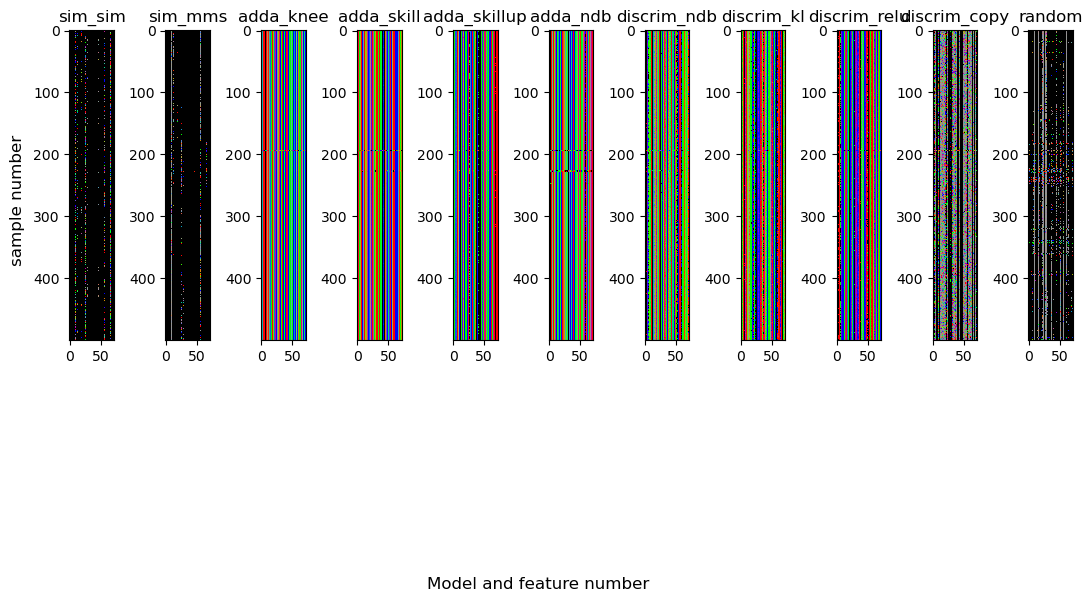

In [26]:
# plot feature pictures
unused_df = feat_extractors_df.index.isin([])#"adda_skillup", "discrim_relu"])
fig, ax= plt.subplots(ncols=len(feat_extractors_df.loc[~unused_df].index), figsize=(11,8))

for axis, (_, row) in zip(ax,feat_extractors_df.loc[~unused_df].iterrows()):
    axis = plot_features(row, comp_data, axis)
fig.supxlabel("Model and feature number")
fig.supylabel("sample number")
fig.tight_layout()
fig.show()
fig.savefig("/tigress/kendrab/analysis-notebooks/model_outs/feat_comparison_all.pdf")

34090 (500, 72, 3)
0.0 1.0
34127 (500, 72, 3)
0.0 0.6334468071576974
15687 (500, 72, 3)
0.0 1.0
26537 (500, 72, 3)
0.0 0.6272739050812177


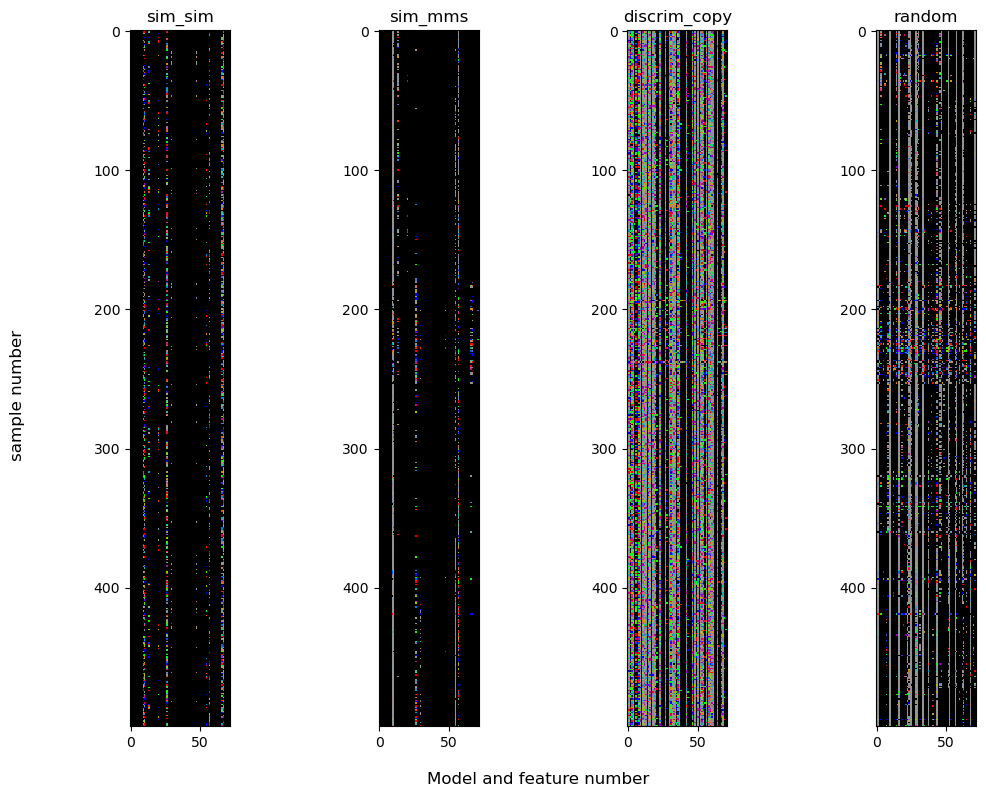

In [27]:
# plot feature pictures
select_df = feat_extractors_df.index.isin(["sim_sim", "sim_mms", "discrim_copy", "random"])
fig, ax= plt.subplots(ncols=len(feat_extractors_df.loc[select_df].index), figsize=(11,8))

for axis, (_, row) in zip(ax,feat_extractors_df.loc[select_df].iterrows()):
    axis = plot_features(row, comp_data, axis)
fig.supxlabel("Model and feature number")
fig.supylabel("sample number")
fig.tight_layout()
fig.show()
fig.savefig("/tigress/kendrab/analysis-notebooks/model_outs/feat_comparison_greyscale.pdf")

In [28]:
# find zero rows of simulation features
sim_features = get_features(feat_extractors_df.loc["sim_sim"], comp_data).numpy()
zeros_false_mask = ~np.all(sim_features==0, axis=(0,2), keepdims=True)
print(zeros_false_mask.shape)
print(zeros_false_mask)

(1, 72, 1)
[[[False]
  [False]
  [False]
  [False]
  [False]
  [False]
  [False]
  [False]
  [False]
  [ True]
  [ True]
  [False]
  [False]
  [ True]
  [False]
  [False]
  [False]
  [False]
  [False]
  [False]
  [ True]
  [False]
  [False]
  [False]
  [False]
  [False]
  [ True]
  [False]
  [False]
  [ True]
  [False]
  [False]
  [False]
  [False]
  [False]
  [False]
  [False]
  [False]
  [False]
  [False]
  [False]
  [False]
  [False]
  [False]
  [False]
  [False]
  [False]
  [ True]
  [False]
  [False]
  [False]
  [False]
  [False]
  [False]
  [ True]
  [False]
  [ True]
  [False]
  [False]
  [False]
  [False]
  [False]
  [False]
  [False]
  [False]
  [ True]
  [ True]
  [False]
  [False]
  [False]
  [False]
  [False]]]


In [29]:
feat_extractors_df

,model,model_path,data,num_runs,hyperparams,weights_mean,weights_stdev,feat_size_mean,ndb_score_25,ndb_score_100,kl_div,js_dist,rope_acc,loop_acc,neg_acc,rope_acc_0,loop_acc_0,neg_acc_0
sim_sim,ModelF(\n (bx_layers): Module(\n (0): Conv...,NaN,sim,NaN,NaN,-0.161843,1.462548,0.032691,0.04,0.03,"tensor(0.1171, dtype=torch.float64)","tensor(0.1731, dtype=torch.float64)",NaN,NaN,NaN,NaN,NaN,NaN
sim_mms,ModelF(\n (bx_layers): Module(\n (0): Conv...,NaN,mms,NaN,NaN,-0.161843,1.462548,0.071397,1.00,0.91,"tensor(0.1992, dtype=torch.float64)","tensor(0.2238, dtype=torch.float64)",NaN,NaN,NaN,NaN,NaN,NaN
adda_knee,MMSFeatExtract(\n (bx_layers): Sequential(\n ...,/tigress/kendrab/analysis-notebooks/model_outs...,mms,993.0,"[{'num_conv': 2, 'kernel_size': 2, 'pool_size'...",0.032662,2.383051,0.054512,0.92,0.91,"tensor(0.0817, dtype=torch.float64)","tensor(0.1451, dtype=torch.float64)",NaN,NaN,NaN,NaN,NaN,NaN
adda_skill,MMSFeatExtract(\n (bx_layers): Sequential(\n ...,/tigress/kendrab/analysis-notebooks/model_outs...,mms,993.0,"[{'num_conv': 2, 'kernel_size': 2, 'pool_size'...",-0.188456,2.621052,0.054306,0.92,0.91,"tensor(0.0971, dtype=torch.float64)","tensor(0.1580, dtype=torch.float64)",NaN,NaN,NaN,NaN,NaN,NaN
adda_skillup,MMSFeatExtract(\n (bx_layers): Sequential(\n ...,/tigress/kendrab/analysis-notebooks/model_outs...,mms,993.0,"[{'num_conv': 2, 'kernel_size': 2, 'pool_size'...",0.109526,1.930137,0.853471,0.92,0.91,"tensor(6.7979, dtype=torch.float64)","tensor(1.3044, dtype=torch.float64)",NaN,NaN,NaN,NaN,NaN,NaN
adda_ndb,MMSFeatExtract(\n (bx_layers): Sequential(\n ...,/tigress/kendrab/analysis-notebooks/model_outs...,mms,289.0,"[{'num_conv': 1, 'kernel_size': 3, 'pool_size'...",-0.042560,1.472003,0.225369,0.92,0.91,"tensor(2.3299, dtype=torch.float64)","tensor(0.7579, dtype=torch.float64)",NaN,NaN,NaN,NaN,NaN,NaN
discrim_ndb,MMSFeatExtract(\n (bx_layers): Sequential(\n ...,/tigress/kendrab/analysis-notebooks/model_outs...,mms,282.0,"[{'num_conv': 1, 'kernel_size': 5, 'pool_size'...",-0.000036,0.026232,0.035018,0.92,0.91,"tensor(0.0703, dtype=torch.float64)","tensor(0.1351, dtype=torch.float64)",NaN,NaN,NaN,NaN,NaN,NaN
discrim_kl,MMSFeatExtract(\n (bx_layers): Sequential(\n ...,/tigress/kendrab/analysis-notebooks/model_outs...,mms,287.0,"[{'num_conv': 2, 'kernel_size': 2, 'pool_size'...",-0.000076,0.038641,0.027137,0.92,0.91,"tensor(0.0647, dtype=torch.float64)","tensor(0.1298, dtype=torch.float64)",NaN,NaN,NaN,NaN,NaN,NaN
discrim_relu,MMSFeatExtract(\n (bx_layers): Sequential(\n ...,/tigress/kendrab/analysis-notebooks/model_outs...,mms,288.0,"[{'num_conv': 2, 'kernel_size': 2, 'pool_size'...",-0.000171,0.039533,0.027305,0.92,0.91,"tensor(0.0651, dtype=torch.float64)","tensor(0.1303, dtype=torch.float64)",NaN,NaN,NaN,NaN,NaN,NaN
discrim_copy,ModelF_Feat(\n (bx_layers): Sequential(\n ...,/tigress/kendrab/analysis-notebooks/model_outs...,mms,289.0,NaN,-0.001891,0.122254,0.071216,0.92,0.91,"tensor(0.0744, dtype=torch.float64)","tensor(0.1388, dtype=torch.float64)",NaN,NaN,NaN,NaN,NaN,NaN


### Load labeled MMS data

In [30]:
# load the datasets
loop_data = get_mms_data("", folder = smith_loop_path)
rope_data = get_mms_data("", folder = smith_rope_path)
negative_data = get_mms_data("", folder = negative_path)
# add labels
loop_data['struct_type'] = np.ones_like(loop_data['time'], dtype=np.float64)[:,:stride]
rope_data['struct_type'] = np.ones_like(rope_data['time'], dtype=np.float64)[:,:stride]
negative_data['struct_type'] = np.zeros_like(negative_data['time'], dtype=np.float64)[:,:stride]
print(loop_data['struct_type'].shape)
print(rope_data['struct_type'].shape)
print(negative_data['struct_type'].shape)
# put in dataloaders
batch_size = 11
loop_dl = format_mms_data(loop_data)
rope_dl = format_mms_data(rope_data)
negative_dl = format_mms_data(negative_data)
loop_num = loop_data['struct_type'].shape[0]
rope_num = rope_data['struct_type'].shape[0]

(14074, 11)
(7957, 11)
(38093, 11)
components loaded in order ['B', 'E', 'j', 'struct_num', 'time', 'struct_type']
components loaded in order ['B', 'E', 'j', 'struct_num', 'time', 'struct_type']
components loaded in order ['B', 'E', 'j', 'time', 'struct_type']


### Data-centric tests

In [31]:
print(len(rope_dl))
feat_extractors_df = feat_extractors_df.apply(lambda x: eval_on_data(x, all_classifier, 'rope_acc', rope_dl, loss_fn, threshold = 0.5, struct_num = True), axis=1)
feat_extractors_df = feat_extractors_df.apply(lambda x: eval_on_data(x, all_classifier, 'loop_acc', loop_dl, loss_fn, threshold = 0.5, struct_num = True), axis=1)
feat_extractors_df = feat_extractors_df.apply(lambda x: eval_on_data(x, all_classifier, 'neg_acc', negative_dl, loss_fn, threshold = 0.5, struct_num = False), axis=1)
# calculate the overall plasmoid recall
feat_extractors_df['plasmoid_acc'] = (feat_extractors_df['rope_acc']*rope_num + feat_extractors_df['loop_acc']*loop_num)/(loop_num+rope_num)

723
7957 11 87527
723
Test Error: 
 Accuracy: 8.51851%, Avg loss: 3.548688 

7957 11 87527
723
Test Error: 
 Accuracy: 8.53108%, Avg loss: 3.547450 

7957 11 87527
723
Test Error: 
 Accuracy: 99.94973%, Avg loss: 0.547696 

7957 11 87527
723
Test Error: 
 Accuracy: 0.00000%, Avg loss: 1.239958 

7957 11 87527
723
Test Error: 
 Accuracy: 0.00000%, Avg loss: 36.932729 

7957 11 87527
723
Test Error: 
 Accuracy: 99.94973%, Avg loss: 0.562160 

7957 11 87527
723
Test Error: 
 Accuracy: 0.00000%, Avg loss: 1.036670 

7957 11 87527
723
Test Error: 
 Accuracy: 0.00000%, Avg loss: 1.412088 

7957 11 87527
723
Test Error: 
 Accuracy: 0.00000%, Avg loss: 0.832190 

7957 11 87527
723
Test Error: 
 Accuracy: 0.00000%, Avg loss: 0.756318 

7957 11 87527
723
Test Error: 
 Accuracy: 0.00000%, Avg loss: 7.776837 

14074 11 154814
1279
Test Error: 
 Accuracy: 2.60765%, Avg loss: 5.006875 

14074 11 154814
1279
Test Error: 
 Accuracy: 2.60765%, Avg loss: 5.007742 

14074 11 154814
1279
Test Error: 
 Acc

In [32]:
these_models=['sim_mms','adda_knee','adda_skill','adda_ndb','discrim_ndb','discrim_kl','discrim_relu','discrim_copy','random']
feat_extractors_df.loc[these_models,['rope_acc','loop_acc','plasmoid_acc','neg_acc']]

,rope_acc,loop_acc,plasmoid_acc,neg_acc
sim_mms,0.085311,0.026076,0.047470,0.975956
adda_knee,0.999497,0.999645,0.999591,0.000000
adda_skill,0.000000,0.000000,0.000000,1.000000
adda_ndb,0.999497,0.999645,0.999591,0.000000
discrim_ndb,0.000000,0.000000,0.000000,1.000000
discrim_kl,0.000000,0.000000,0.000000,1.000000
discrim_relu,0.000000,0.000000,0.000000,1.000000
discrim_copy,0.000000,0.000000,0.000000,1.000000
random,0.000000,0.000000,0.000000,1.000000


In [33]:
# try zeroing all the features that sim_sim says are zero
feat_extractors_df = feat_extractors_df.apply(lambda x: eval_on_data(x, all_classifier, 'rope_acc_0', rope_dl, loss_fn, threshold = 0.5, struct_num = True, mask=zeros_false_mask), axis=1)
feat_extractors_df = feat_extractors_df.apply(lambda x: eval_on_data(x, all_classifier, 'loop_acc_0', loop_dl, loss_fn, threshold = 0.5, struct_num = True, mask=zeros_false_mask), axis=1)
feat_extractors_df = feat_extractors_df.apply(lambda x: eval_on_data(x, all_classifier, 'neg_acc_0', negative_dl, loss_fn, threshold = 0.5, struct_num = False, mask=zeros_false_mask), axis=1)
feat_extractors_df['plasmoid_acc_0'] = (feat_extractors_df['rope_acc_0']*rope_num + feat_extractors_df['loop_acc_0']*loop_num)/(loop_num+rope_num)

7957 11 87527
723
Test Error: 
 Accuracy: 8.51851%, Avg loss: 3.548178 

7957 11 87527
723
Test Error: 
 Accuracy: 8.50595%, Avg loss: 3.548190 

7957 11 87527
723
Test Error: 
 Accuracy: 99.94973%, Avg loss: 0.546564 

7957 11 87527
723
Test Error: 
 Accuracy: 0.00000%, Avg loss: 1.239377 

7957 11 87527
723
Test Error: 
 Accuracy: 0.00000%, Avg loss: 36.303348 

7957 11 87527
723
Test Error: 
 Accuracy: 99.94973%, Avg loss: 0.547679 

7957 11 87527
723
Test Error: 
 Accuracy: 0.00000%, Avg loss: 1.025999 

7957 11 87527
723
Test Error: 
 Accuracy: 0.00000%, Avg loss: 1.403998 

7957 11 87527
723
Test Error: 
 Accuracy: 0.00000%, Avg loss: 0.823086 

7957 11 87527
723
Test Error: 
 Accuracy: 0.00000%, Avg loss: 0.715673 

7957 11 87527
723
Test Error: 
 Accuracy: 0.00000%, Avg loss: 7.721908 

14074 11 154814
1279
Test Error: 
 Accuracy: 2.60765%, Avg loss: 5.007260 

14074 11 154814
1279
Test Error: 
 Accuracy: 2.60765%, Avg loss: 5.006405 

14074 11 154814
1279
Test Error: 
 Accurac

In [34]:
feat_extractors_df.loc[these_models,['rope_acc_0','loop_acc_0', 'plasmoid_acc_0', 'neg_acc_0']]

,rope_acc_0,loop_acc_0,plasmoid_acc_0,neg_acc_0
sim_mms,0.085059,0.026076,0.047380,0.975956
adda_knee,0.999497,0.999645,0.999591,0.000000
adda_skill,0.000000,0.000000,0.000000,1.000000
adda_ndb,0.999497,0.999645,0.999591,0.000000
discrim_ndb,0.000000,0.000000,0.000000,1.000000
discrim_kl,0.000000,0.000000,0.000000,1.000000
discrim_relu,0.000000,0.000000,0.000000,1.000000
discrim_copy,0.000000,0.000000,0.000000,1.000000
random,0.000000,0.000000,0.000000,1.000000
